<a href="https://colab.research.google.com/github/Xinxinatg/CSRNet-pytorch/blob/master/CRSnet_makedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/vivek-bombatkar/CSRNet-pytorch.git

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 625.58 KiB | 26.07 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Mounted at /content/drive


In [2]:
!unzip -q /content/drive/'My Drive'/ShanghaiTech_Crowd_Counting_Dataset.zip

In [3]:
import h5py
import scipy.io as io
import sys
sys.path.extend(['/content/CSRNet-pytorch'])
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [4]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print gt.shape
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print 'generate density...'
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print 'done.'
    return density

In [5]:
#set the root to the Shanghai dataset you download
root = '/content'

In [6]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [7]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [8]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/part_A_final/train_data/images/IMG_245.jpg
(825, 1024)
generate density...
done.
/content/part_A_final/train_data/images/IMG_40.jpg
(388, 576)
generate density...
done.
/content/part_A_final/train_data/images/IMG_201.jpg
(530, 800)
generate density...
done.
/content/part_A_final/train_data/images/IMG_130.jpg
(680, 1024)
generate density...
done.
/content/part_A_final/train_data/images/IMG_170.jpg
(480, 722)
generate density...
done.
/content/part_A_final/train_data/images/IMG_286.jpg
(578, 779)
generate density...
done.
/content/part_A_final/train_data/images/IMG_291.jpg
(768, 1024)
generate density...
done.
/content/part_A_final/train_data/images/IMG_213.jpg
(749, 1000)
generate density...
done.
/content/part_A_final/train_data/images/IMG_90.jpg
(576, 1024)
generate density...
done.
/content/part_A_final/train_data/images/IMG_112.jpg
(327, 1024)
generate density...
done.
/content/part_A_final/train_data/images/IMG_154.jpg
(416, 624)
generate density...
done.
/content/part_A_f

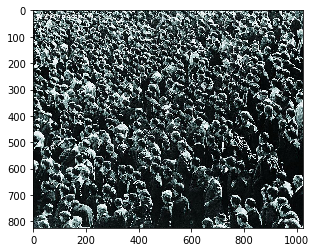

In [9]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

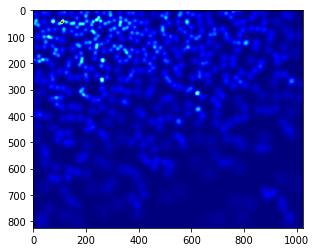

In [10]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [11]:
np.sum(groundtruth)# don't mind this slight variation

479.21646

In [12]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [13]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [14]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/part_B_final/train_data/images/IMG_245.jpg
/content/part_B_final/train_data/images/IMG_308.jpg
/content/part_B_final/train_data/images/IMG_40.jpg
/content/part_B_final/train_data/images/IMG_346.jpg
/content/part_B_final/train_data/images/IMG_201.jpg
/content/part_B_final/train_data/images/IMG_372.jpg
/content/part_B_final/train_data/images/IMG_130.jpg
/content/part_B_final/train_data/images/IMG_170.jpg
/content/part_B_final/train_data/images/IMG_286.jpg
/content/part_B_final/train_data/images/IMG_291.jpg
/content/part_B_final/train_data/images/IMG_213.jpg
/content/part_B_final/train_data/images/IMG_90.jpg
/content/part_B_final/train_data/images/IMG_112.jpg
/content/part_B_final/train_data/images/IMG_154.jpg
/content/part_B_final/train_data/images/IMG_128.jpg
/content/part_B_final/train_data/images/IMG_336.jpg
/content/part_B_final/train_data/images/IMG_292.jpg
/content/part_B_final/train_data/images/IMG_288.jpg
/content/part_B_final/train_data/images/IMG_48.jpg
/content/part_B

In [ ]:


!python /content/CSRNet-pytorch/train.py /content/part_A_train_v1.1.json /content/part_A_val_v1.1.json 0 0 

/usr/local/lib/python2.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 0, processed 0 samples, lr 0.0000001000
Epoch: [0][0/1200]	Time 0.264 (0.264)	Data 0.053 (0.053)	Loss 48.2373 (48.2373)	
Epoch: [0][30/1200]	Time 0.319 (0.258)	Data 0.037 (0.033)	Loss 1290.3088 (274.0607)	
Epoch: [0][60/1200]	Time 0.155 (0.251)	Data 0.040 (0.031)	Loss 26.3439 (423.0339)	
Epoch: [0][90/1200]	Time 0.215 (0.249)	Data 0.034 (0.029)	Loss 27.9995 (427.8122)	
Epoch: [0][120/1200]	Time 0.364 (0.260)	Data 0.025 (0.029)	Loss 54.2062 (438.8356)	
Epoch: [0][150/1200]	Time 0.242 (0.262)	Data 0.016 (0.028)	Loss 125.5484 (417.3546)	
Epoch: [0][180/1200]	Time 0.345 (0.265)	Data 0.035 (0.029)	Loss 480.2360 (386.4022)	
Epoch: [0][210/1200]	Time 0.280 (0.270)	Data 0.025 (0.028)	Loss 3964.0132 (370.2408)	
Epoch: [0][240/1200]	Time 0.153 (0.269)	Data 0.013 (0.027)	Loss 1476.2573 (374.54

In [19]:
#!zip -r part_B_final.zip /content/part_B_final

  adding: content/part_B_final/ (stored 0%)
  adding: content/part_B_final/train_data/ (stored 0%)
  adding: content/part_B_final/train_data/images/ (stored 0%)
  adding: content/part_B_final/train_data/images/IMG_245.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_308.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_40.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_346.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_201.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_372.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_130.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_170.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_286.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_291.jpg (deflated 0%)
  adding: content/part_B_final/train_data/images/IMG_213.jpg (deflated 0%)
  adding: conte